# ライブラリのインポート

In [503]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

plt.rcParams['font.family'] = 'Hiragino Sans' # Mac用の日本語フォント設定
# Windowsの場合は 'MS Gothic' などに変更



# データのインポート

In [94]:
df = pd.read_csv('../01_src/.data/customer_cases.csv', index_col=0)


print(df.shape)
print(df.head(2))


(330512, 5)
  case_id            date_time customer_id channel  reason
1   CC101  2017-01-01 10:32:03       C2448   phone  signup
2   CC102  2017-01-01 11:35:47       C2449   phone  signup


# データの前処理

## data_timeを日付・時刻のデータ型に変更する

pythonの日付・時刻のデー型は以下のような種類がある。  
| 型名                     | 説明                                |
| ---------------------- | --------------------------------- |
| `datetime.datetime`    | 日付＋時刻（例：2023-01-01 12:34:56）      |
| `datetime.date`        | 日付のみ（例：2023-01-01）                |
| `datetime.time`        | 時刻のみ（例：12:34:56）                  |
| `datetime.timedelta`   | 2つの日時の差（例：3日, 5時間など）              |
| `pandas.Timestamp`     | pandas版の日時（`datetime64[ns]`のラッパー） |
| `pandas.Timedelta`     | pandas版の時間差（例：'7 days', '3h'）     |
| `pandas.Period`        | 特定の期間（例：月、四半期など）                  |
| `pandas.DatetimeIndex` | 時系列インデックス（複数の Timestamp）          |
| `numpy.datetime64`     | NumPyベースの日時型（pandasでも内部で使用）       |  
  


In [365]:
# dateをdatetime型に変換
df1 =df.copy()
df1['date_time'] = pd.to_datetime(df1['date_time'])

# date列を作成する
df1['date'] = df1['date_time'].dt.date

## channelとreason列の処理

In [367]:
# 列の値を確認する
print("======== channel ===========")
print(df1['channel'].value_counts())
print("\n======== reason ===========")
print(df1['reason'].value_counts())



======== channel ===========
channel
phone    286840
email     43672
Name: count, dtype: int64

======== reason ===========
reason
support    200985
signup     129527
Name: count, dtype: int64


In [370]:
# channelがphoneかどうかを判定する列を追加
df1['channel_phone'] = df1['channel'] == 'phone'
print(df1['channel_phone'].value_counts())

channel_phone
True     286840
False     43672
Name: count, dtype: int64


In [372]:
# int型に変換
df1['channel_phone'] = df1['channel_phone'].astype(int)
print(df1['channel_phone'].value_counts())

channel_phone
1    286840
0     43672
Name: count, dtype: int64


In [374]:
# # 同様に他の列も作成する

# channelがemailかどうかを判定する列を追加
df1['channel_email'] = (df1['channel'] == 'email').astype(int)

# channelがwebかどうかを判定する列を追加
df1['reason_signup'] = (df1['reason'] == 'signup').astype(int) 

# reasonがsupportかどうかを判定する列を追加
df1['reason_support'] = (df1['reason'] == 'support').astype(int)

## 日付単位で集計する

In [376]:
# # groupbyで集計
# dateごとにchannel_phone, channel_email, reason_signup, reason_supportの合計を求め、customer_idの数をカウントする
df2 = df1.groupby(
  'date', # dateをグループ化のキーにする
  as_index=False # as_index=Falseを指定して、dateをインデックスにしないようにする
  ).agg(
     # agg関数を使って、各列の集計方法を指定する
      {
        'channel_phone': 'sum', 
        'channel_email':'sum', 
        'reason_signup': 'sum', 
        'reason_support': 'sum', 
        'customer_id': 'count'
      }
    )

# 列名を変更
df2.rename(columns={'customer_id': 'customer_count'}, inplace=True)


# 行数と列数を表示
print(df2.shape)

# 最初の5行を表示
display(df2.head(5))


(1827, 6)


,date,channel_phone,channel_email,reason_signup,reason_support,customer_count
0,2017-01-01,7,0,7,0,7
1,2017-01-02,56,0,56,0,56
2,2017-01-03,49,0,48,1,49
3,2017-01-04,54,0,54,0,54
4,2017-01-05,58,0,58,0,58


## 可視化してデータの中身を確認する

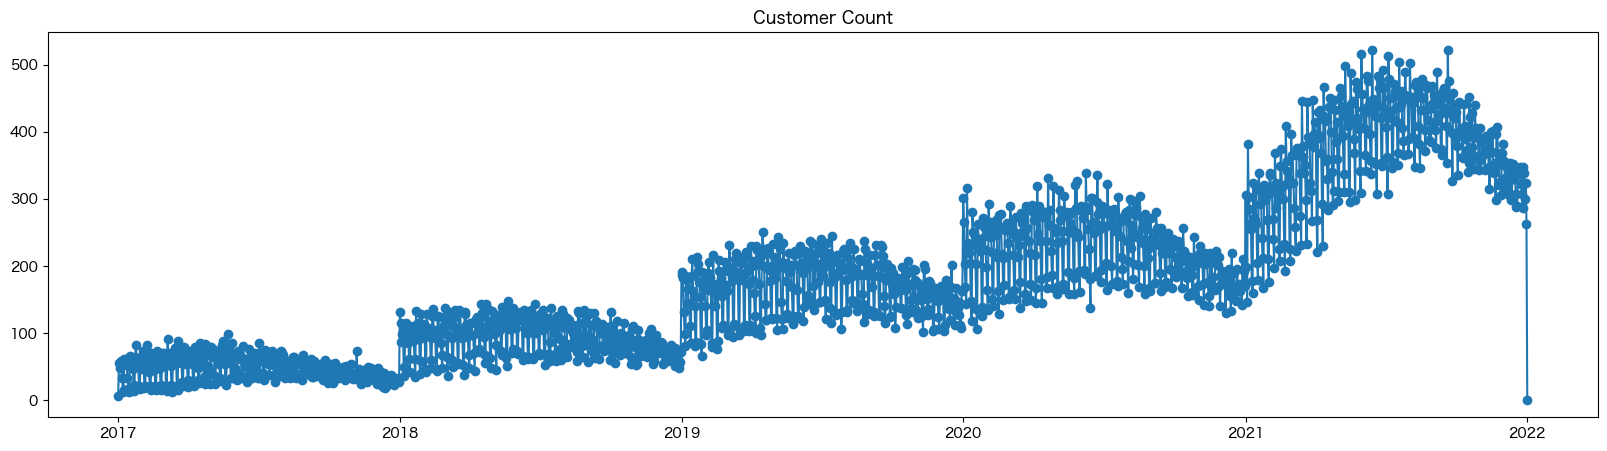

In [377]:
# customer_countの推移をプロット

plt.figure(figsize=(20, 5)) # グラフのサイズを指定
plt.plot(df2['date'], df2['customer_count'], marker='o') # dateをx軸、customer_countをy軸にしてプロット
plt.title('Customer Count') # グラフのタイトルを設定
plt.show() # グラフを表示

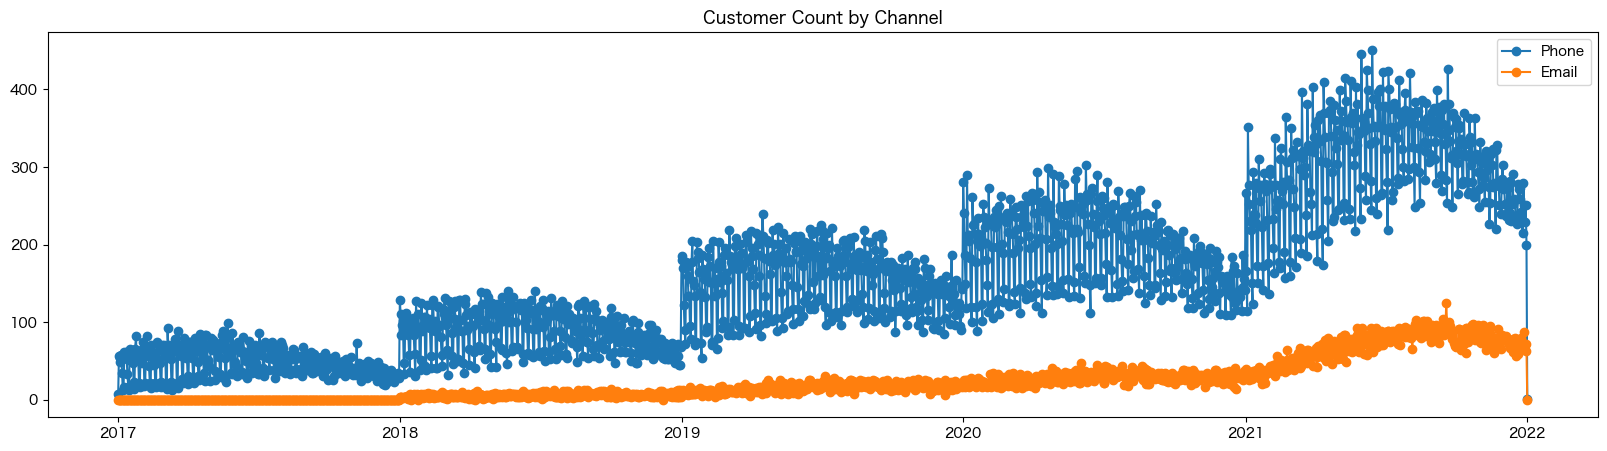

In [ ]:
# channelごとのカウントをプロット

plt.figure(figsize=(20, 5))
plt.plot(df2['date'], df2['channel_phone'], marker='o')
plt.plot(df2['date'], df2['channel_email'], marker='o')
plt.title('Customer Count by Channel')
plt.legend(['Phone', 'Email'])
plt.show()


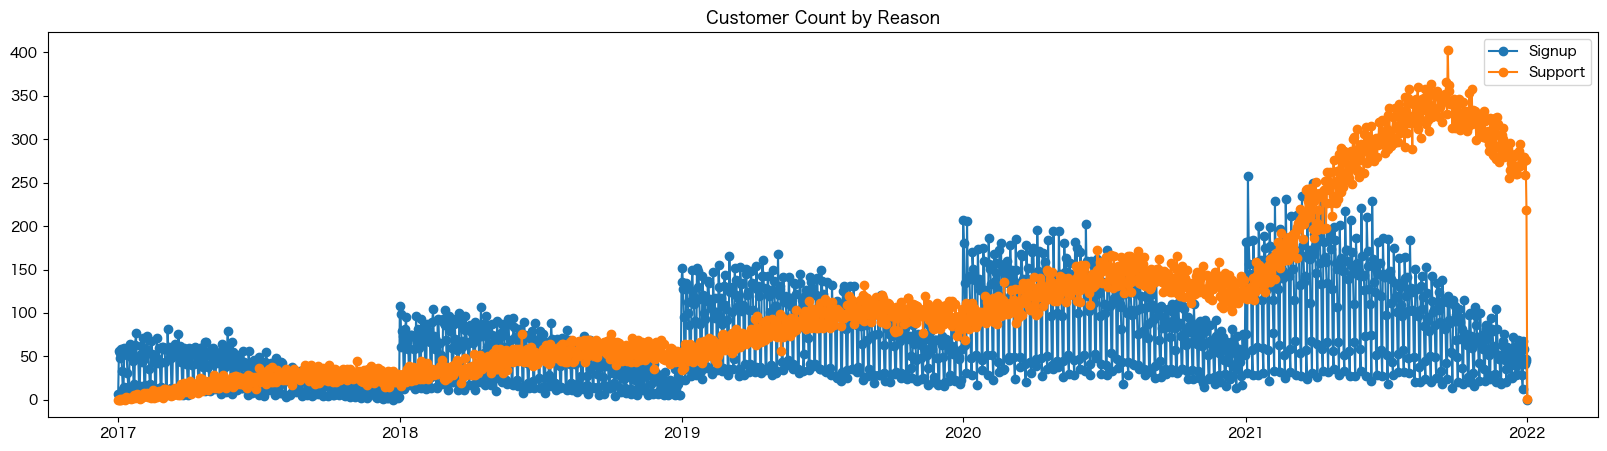

In [379]:
# reasonごとのカウントをプロット
plt.figure(figsize=(20, 5))
plt.plot(df2['date'], df2['reason_signup'], marker='o')
plt.plot(df2['date'], df2['reason_support'], marker='o')
plt.title('Customer Count by Reason')
plt.legend(['Signup', 'Support'])
plt.show()

# 機械学習用に特徴量を作成する

## dateをindexに設定する

In [451]:
print("== 元のindex ==")
print(df2.index)

# 日付をインデックスに設定
df3 = df2.set_index('date')

print("\n\n== 処理後のindex ==")
print(df3.index)


== 元のindex ==
RangeIndex(start=0, stop=1827, step=1)


== 処理後のindex ==
Index([2017-01-01, 2017-01-02, 2017-01-03, 2017-01-04, 2017-01-05, 2017-01-06,
       2017-01-07, 2017-01-08, 2017-01-09, 2017-01-10,
       ...
       2021-12-23, 2021-12-24, 2021-12-25, 2021-12-26, 2021-12-27, 2021-12-28,
       2021-12-29, 2021-12-30, 2021-12-31, 2022-01-01],
      dtype='object', name='date', length=1827)


## 必要な列をのみを抽出

In [452]:
# cusstomer_countとreason_supportの列を抽出
df3 = df3[['customer_count','reason_support']].copy()
df3


,customer_count,reason_support
date,,
2017-01-01,7,0
2017-01-02,56,0
2017-01-03,49,1
2017-01-04,54,0
2017-01-05,58,0
...,...,...
2021-12-28,338,279
2021-12-29,300,259
2021-12-30,323,276


## 年、月の列を作成

In [453]:
# indexをdatetime型に変換
df3.index = pd.to_datetime(df3.index)

# indexをもとにyearとmonthの列を追加
df3['year'] = df3.index.year
df3['month'] = df3.index.month

df3

,customer_count,reason_support,year,month
date,,,,
2017-01-01,7,0,2017,1
2017-01-02,56,0,2017,1
2017-01-03,49,1,2017,1
2017-01-04,54,0,2017,1
2017-01-05,58,0,2017,1
...,...,...,...,...
2021-12-28,338,279,2021,12
2021-12-29,300,259,2021,12
2021-12-30,323,276,2021,12


##  LAGを作成する

In [ ]:
# # lagを作成する
# 1日ずつずらす
tdf = tdf.copy()
tdf['lag1_customer_count'] = tdf['customer_count'].shift(1)
tdf['lag2_customer_count'] = tdf['customer_count'].shift(2)
tdf['lag3_customer_count'] = tdf['customer_count'].shift(3)



# printして確認
print("\n== lag1 ==")
print(tdf['lag1_customer_count'].head(5))
print("\n== lag2 ==")
print(tdf['lag2_customer_count'].head(5))
print("\n== lag3 ==")
print(tdf['lag3_customer_count'].head(5))


== lag1 ==
date
2017-01-01     NaN
2017-01-02     7.0
2017-01-03    56.0
2017-01-04    49.0
2017-01-05    54.0
Name: lag1_customer_count, dtype: float64

== lag2 ==
date
2017-01-01     NaN
2017-01-02     NaN
2017-01-03     7.0
2017-01-04    56.0
2017-01-05    49.0
Name: lag2_customer_count, dtype: float64

== lag3 ==
date
2017-01-01     NaN
2017-01-02     NaN
2017-01-03     NaN
2017-01-04     7.0
2017-01-05    56.0
Name: lag3_customer_count, dtype: float64


In [454]:
# # forループを使ってlag列を作成する

for i in range(1, 15): # 14日分のlag列を作成する

  # customer_count列をi日ずらして新しい列を作成
  col = f'lag{i}_customer_count' # lag列の名前を作成
  df3[col] = df3['customer_count'].shift(i) # customer_count列をi日ずらして新しい列を作成

  # reason_support列をi日ずらして新しい列を作成
  col = f'lag{i}_reason_support' # lag列の名前を作成
  df3[col] = df3['reason_support'].shift(i) # reason_support列をi日ずらして新しい列を作成

df3.iloc[:, -28:] # 最後の30列を表示して確認

,lag1_customer_count,lag1_reason_support,lag2_customer_count,lag2_reason_support,lag3_customer_count,lag3_reason_support,lag4_customer_count,lag4_reason_support,lag5_customer_count,lag5_reason_support,...,lag10_customer_count,lag10_reason_support,lag11_customer_count,lag11_reason_support,lag12_customer_count,lag12_reason_support,lag13_customer_count,lag13_reason_support,lag14_customer_count,lag14_reason_support
date,,,,,,,,,,,,,,,,,,,,,
2017-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-02,7.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-03,56.0,0.0,7.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-04,49.0,1.0,56.0,0.0,7.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-05,54.0,0.0,49.0,1.0,56.0,0.0,7.0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-28,347.0,279.0,286.0,274.0,307.0,279.0,322.0,280.0,348.0,294.0,...,288.0,260.0,308.0,269.0,338.0,283.0,329.0,268.0,330.0,281.0
2021-12-29,338.0,279.0,347.0,279.0,286.0,274.0,307.0,279.0,322.0,280.0,...,290.0,260.0,288.0,260.0,308.0,269.0,338.0,283.0,329.0,268.0
2021-12-30,300.0,259.0,338.0,279.0,347.0,279.0,286.0,274.0,307.0,279.0,...,337.0,268.0,290.0,260.0,288.0,260.0,308.0,269.0,338.0,283.0


## GAPを作成する

In [456]:
tdf = df3.copy()

tdf['gap1_customer_count'] = tdf['customer_count'] - tdf['lag1_customer_count']

# printして確認
print("\n== gap1_customer_count ==")
print(tdf[['customer_count','lag1_customer_count','gap1_customer_count']].head(5))



== gap1_customer_count ==
            customer_count  lag1_customer_count  gap1_customer_count
date                                                                
2017-01-01               7                  NaN                  NaN
2017-01-02              56                  7.0                 49.0
2017-01-03              49                 56.0                 -7.0
2017-01-04              54                 49.0                  5.0
2017-01-05              58                 54.0                  4.0


In [457]:
# forループを使ってgap列を作成する
for i in range(1, 15): # 14日分のgap列を作成する

  # customer_count列とi日ずらしたcustomer_count列の差を計算して新しい列を作成
  col = f'gap{i}_customer_count' # gap列の名前を作成
  # customer_count列とi日ずらしたcustomer_count列の差を計算して新しい列を作成
  df3[col] = df3['customer_count'] - df3[f'lag{i}_customer_count']

  # reason_support列とi日ずらしたreason_support列の差を計算して新しい列を作成
  col = f'gap{i}_reason_support' # gap列の名前を作成
  # reason_support列とi日ずらしたreason_support列の差を計算して新しい列を作成
  df3[col] = df3['reason_support'] - df3[f'lag{i}_reason_support']

df3.iloc[:, -28:] # 最後の28列を表示して確認

,gap1_customer_count,gap1_reason_support,gap2_customer_count,gap2_reason_support,gap3_customer_count,gap3_reason_support,gap4_customer_count,gap4_reason_support,gap5_customer_count,gap5_reason_support,...,gap10_customer_count,gap10_reason_support,gap11_customer_count,gap11_reason_support,gap12_customer_count,gap12_reason_support,gap13_customer_count,gap13_reason_support,gap14_customer_count,gap14_reason_support
date,,,,,,,,,,,,,,,,,,,,,
2017-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-02,49.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-03,-7.0,1.0,42.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-04,5.0,-1.0,-2.0,0.0,47.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-05,4.0,0.0,9.0,-1.0,2.0,0.0,51.0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-28,-9.0,0.0,52.0,5.0,31.0,0.0,16.0,-1.0,-10.0,-15.0,...,50.0,19.0,30.0,10.0,0.0,-4.0,9.0,11.0,8.0,-2.0
2021-12-29,-38.0,-20.0,-47.0,-20.0,14.0,-15.0,-7.0,-20.0,-22.0,-21.0,...,10.0,-1.0,12.0,-1.0,-8.0,-10.0,-38.0,-24.0,-29.0,-9.0
2021-12-30,23.0,17.0,-15.0,-3.0,-24.0,-3.0,37.0,2.0,16.0,-3.0,...,-14.0,8.0,33.0,16.0,35.0,16.0,15.0,7.0,-15.0,-7.0


## 移動平均を作成する

In [458]:
tdf = tdf.copy()

tdf['ma3_customer_count'] = tdf['customer_count'].rolling(window=3).mean()
tdf['ma7_customer_count'] = tdf['customer_count'].rolling(window=7).mean()

# printして確認
print("\n== ma3_customer_count ==")
print(tdf[['customer_count', 'ma3_customer_count']].head(10))
print("\n== ma7_customer_count ==")
print(tdf[['customer_count', 'ma7_customer_count']].head(10))


== ma3_customer_count ==
            customer_count  ma3_customer_count
date                                          
2017-01-01               7                 NaN
2017-01-02              56                 NaN
2017-01-03              49           37.333333
2017-01-04              54           53.000000
2017-01-05              58           53.666667
2017-01-06              34           48.666667
2017-01-07              13           35.000000
2017-01-08              16           21.000000
2017-01-09              61           30.000000
2017-01-10              59           45.333333

== ma7_customer_count ==
            customer_count  ma7_customer_count
date                                          
2017-01-01               7                 NaN
2017-01-02              56                 NaN
2017-01-03              49                 NaN
2017-01-04              54                 NaN
2017-01-05              58                 NaN
2017-01-06              34                 NaN
2017-01-

In [459]:
# forループを使って移動平均列を作成する
for i in range(3, 15): # 3日から14日までの移動平均列を作成する
    col = f'ma{i}_customer_count' # 移動平均列の名前を作成
    df3[col] = df3['customer_count'].rolling(window=i).mean() # 移動平均を計算して新しい列を作成

df3.iloc[:, -12:] # 最後の28列を表示して確認

,ma3_customer_count,ma4_customer_count,ma5_customer_count,ma6_customer_count,ma7_customer_count,ma8_customer_count,ma9_customer_count,ma10_customer_count,ma11_customer_count,ma12_customer_count,ma13_customer_count,ma14_customer_count
date,,,,,,,,,,,,
2017-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-03,37.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-04,53.000000,41.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-05,53.666667,54.25,44.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-28,323.666667,319.50,320.0,324.666667,326.428571,327.750,328.777778,324.9,321.545455,320.416667,321.769231,322.285714
2021-12-29,328.333333,317.75,315.6,316.666667,321.142857,323.125,324.666667,325.9,322.636364,319.750000,318.846154,320.214286
2021-12-30,320.333333,327.00,318.8,316.833333,317.571429,321.375,323.111111,324.5,325.636364,322.666667,320.000000,319.142857


## 曜日列を作成する

In [464]:
# indexから曜日を取得する
day_name = pd.to_datetime(df3.index).day_name()
print("\n== 曜日 ==")
print(day_name)  



== 曜日 ==
Index(['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday',
       'Saturday', 'Sunday', 'Monday', 'Tuesday',
       ...
       'Thursday', 'Friday', 'Saturday', 'Sunday', 'Monday', 'Tuesday',
       'Wednesday', 'Thursday', 'Friday', 'Saturday'],
      dtype='object', name='date', length=1827)


In [467]:
# pandasのget_dummiesを使って曜日をダミー変数化する
df_day_dummies = pd.get_dummies(day_name, prefix='day', drop_first=True) # drop_first=Trueで最初の列を削除
df_day_dummies = df_day_dummies.set_index(df3.index) # 元のindexを保持するためにindexを設定


print("\n== 曜日ダミー変数 ==")
display(df_day_dummies.head(5))


== 曜日ダミー変数 ==


,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday
date,,,,,,
2017-01-01,False,False,True,False,False,False
2017-01-02,True,False,False,False,False,False
2017-01-03,False,False,False,False,True,False
2017-01-04,False,False,False,False,False,True
2017-01-05,False,False,False,True,False,False


In [ ]:
# ダミー変数を結合する
df3 = pd.concat([df3, df_day_dummies], axis=1) # axis=1で列方向に結合
df3.iloc[:, -6:] # 最後の6列を表示して確認

,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday
date,,,,,,
2017-01-01,False,False,True,False,False,False
2017-01-02,True,False,False,False,False,False
2017-01-03,False,False,False,False,True,False
2017-01-04,False,False,False,False,False,True
2017-01-05,False,False,False,True,False,False
...,...,...,...,...,...,...
2021-12-28,False,False,False,False,True,False
2021-12-29,False,False,False,False,False,True
2021-12-30,False,False,False,True,False,False


# 機械学習モデルを作成する

In [471]:
df3[['customer_count']].tail()

,customer_count
date,
2021-12-28,338
2021-12-29,300
2021-12-30,323
2021-12-31,263
2022-01-01,1


## 目的変数と説明変数に分ける

In [476]:
# 2021/12/31までのデータにする
end_date = '2021-12-31'
df4 = df3[df3.index < end_date].copy()

# 目的変数をyとし、説明変数をxに設定
y = df4[['customer_count']]

# 'customer_count'と'reason_support'列を除外
# reason_supportはリークを防ぐために除外
x = df4.drop(columns=['customer_count', 'reason_support'])


# 確認
print("== x ==")
display(x)

print("\n== y ==")
display(y)


== x ==


,year,month,lag1_customer_count,lag1_reason_support,lag2_customer_count,lag2_reason_support,lag3_customer_count,lag3_reason_support,lag4_customer_count,lag4_reason_support,...,ma11_customer_count,ma12_customer_count,ma13_customer_count,ma14_customer_count,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday
date,,,,,,,,,,,,,,,,,,,,,
2017-01-01,2017,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,False,False,True,False,False,False
2017-01-02,2017,1,7.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,True,False,False,False,False,False
2017-01-03,2017,1,56.0,0.0,7.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,False,False,False,False,True,False
2017-01-04,2017,1,49.0,1.0,56.0,0.0,7.0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,False,False,False,False,False,True
2017-01-05,2017,1,54.0,0.0,49.0,1.0,56.0,0.0,7.0,0.0,...,NaN,NaN,NaN,NaN,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-26,2021,12,307.0,279.0,322.0,280.0,348.0,294.0,337.0,269.0,...,318.000000,318.916667,319.769231,322.071429,False,False,True,False,False,False
2021-12-27,2021,12,286.0,274.0,307.0,279.0,322.0,280.0,348.0,294.0,...,318.818182,320.416667,321.076923,321.714286,True,False,False,False,False,False
2021-12-28,2021,12,347.0,279.0,286.0,274.0,307.0,279.0,322.0,280.0,...,321.545455,320.416667,321.769231,322.285714,False,False,False,False,True,False



== y ==


,customer_count
date,
2017-01-01,7
2017-01-02,56
2017-01-03,49
2017-01-04,54
2017-01-05,58
...,...
2021-12-26,286
2021-12-27,347
2021-12-28,338


## 学習データセットと予測データセットに分割

In [477]:
# 2021/11/01をcut_off_dateとして、trainとtestに分割する
cut_off_date = '2021-11-01'

# # cut_off_dateより前のデータをtrain、cut_off_date以降のデータをtestとする
# trainデータ
X_train =  x[x.index < cut_off_date]
y_train = y[y.index < cut_off_date]
# testデータ
X_test = x[x.index >= cut_off_date]
y_test = y[y.index >= cut_off_date]

# 確認
print(f'trainの期間: {X_train.index.min()} ~ {X_train.index.max()}')
print(f'testの期間: {X_test.index.min()} ~ {X_test.index.max()}')

trainの期間: 2017-01-01 00:00:00 ~ 2021-10-31 00:00:00
testの期間: 2021-11-01 00:00:00 ~ 2021-12-30 00:00:00


## モデルの作成

 📘 回帰モデルの主な種類

 1. 回帰モデルとは？

- **目的**：ある数値（例：売上、件数、価格など）を予測する
- **出力**：連続値（0, 10.5, 300.75 など）

---

 2. 主な回帰モデルの種類と特徴

| モデル名                   | 特徴・説明 |
|----------------------------|------------|
| **線形回帰**               | シンプルで直線的な関係を予測。基礎モデル。 |
| **リッジ回帰 / ラッソ回帰** | 線形回帰に正則化を加えたモデル。過学習を防止。 |
| **決定木回帰**             | 条件分岐（if）のように予測。非線形の関係も捉える。 |
| **ランダムフォレスト回帰** | 複数の決定木を平均。精度が高く安定。 |
| **勾配ブースティング回帰（GBDT）** | 木を何本も使って予測精度を少しずつ向上させる強力なモデル。 |
| **LightGBM（今回使用）**  | GBDT の高速・高性能版。大規模データにも強い。 |

---

 3. 今回はLightGBM を採用

 ✅ 初学者にやさしく、実務にも強い

- **精度が高い**：少ない調整でも良い予測結果が得られる  
- **学習・予測が速い**：大量データでも処理が速く、時間効率が良い  
- **欠損値・カテゴリ変数に強い**：前処理がシンプルで済む  
- **特徴量の重要度がわかる**：どの変数が効いているかを可視化できる  
- **Kaggle や実務で実績豊富**：コミュニティやドキュメントも充実  

---

 4. LightGBM の特徴まとめ

| 項目               | 内容 |
|--------------------|------|
| モデルの種類       | 勾配ブースティング回帰（GBDT） |
| ベースモデル       | 決定木 |
| 学習速度           | 非常に高速（他モデルより速い） |
| 欠損値への対応     | 自動で処理可能 |
| カテゴリ変数対応   | `categorical_feature` の指定でOK |
| 特徴量重要度出力   | `.feature_importances_` で可視化可能 |

---

📌 結論：  
初学者にとって「精度・速さ・扱いやすさ」のバランスが良く、**LightGBMはまず試すべき回帰モデル**のひとつです。


## LightGBMでモデルを作成

In [478]:
# LightGBMのモデルを作成し、学習する
model = lgb.LGBMRegressor() # LightGBMの回帰モデルを使用
# モデルのハイパーパラメータはデフォルト値を使用
# モデルを学習する
model.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001374 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13990
[LightGBM] [Info] Number of data points in the train set: 1765, number of used features: 76
[LightGBM] [Info] Start training from score 175.390368


LGBMRegressor()

## 予測を行う

In [488]:
# predictメソッドを使って予測を行う
y_pred = model.predict(X_test)  

# 予測値と実際の値を比較する
print("== 予測値 ==")
print(y_pred[:20].astype(int))  # 最初の5つの予測値を表示
print("\n== 実際の値 ==")
print(y_test['customer_count'].values[:20])  # 最初の5つの実際の値を表示 

== 予測値 ==
[414 400 380 373 380 370 351 404 396 377 378 356 335 353 402 370 395 351
 343 350]

== 実際の値 ==
[406 385 385 365 387 369 343 382 393 378 389 347 315 348 400 370 401 344
 339 354]


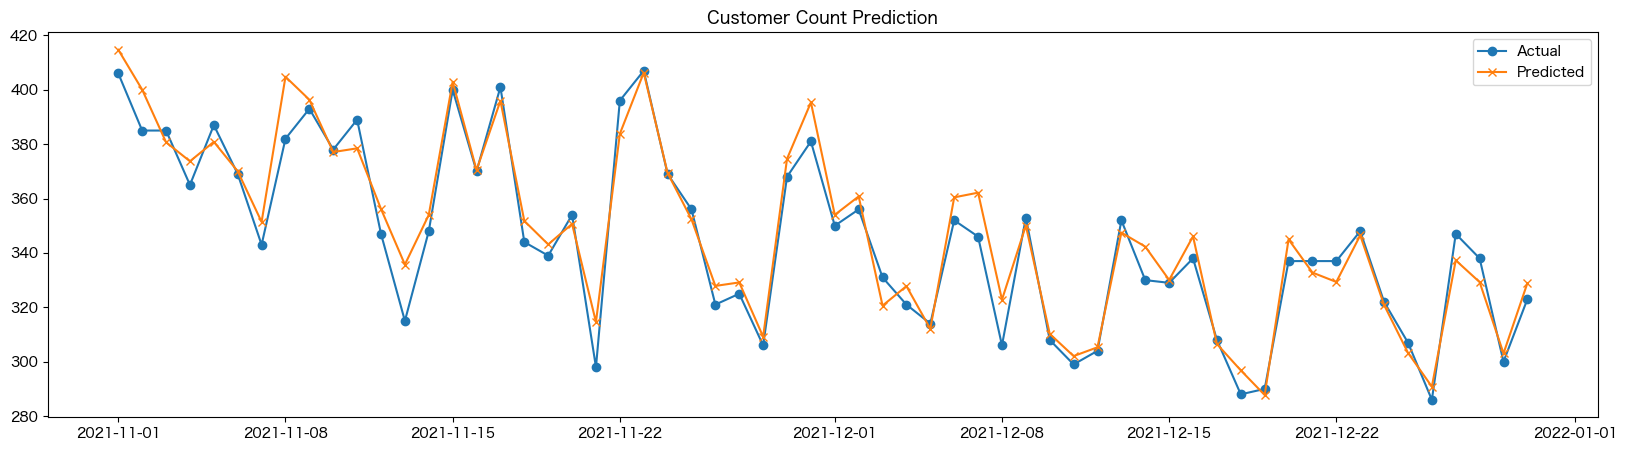

In [489]:
# 予測値と実際の値を可視化する
plt.figure(figsize=(20, 5))
plt.plot(X_test.index, y_test, marker='o', label='Actual')
plt.plot(X_test.index, y_pred, marker='x', label='Predicted')
plt.title('Customer Count Prediction')
plt.legend()
plt.show()  

## 精度を検証する

 🎯 主な評価指標一覧

| 指標名         | 説明 |
|----------------|------|
| **MAE**（平均絶対誤差） | 誤差の平均（絶対値）。外れ値の影響を受けにくい。 |
| **MSE**（平均二乗誤差） | 誤差を2乗して平均。大きな誤差をより重視する。 |
| **RMSE**（二乗平均平方根誤差） | MSEの平方根。単位が元のデータと同じになる。 |
| **R²**（決定係数）       | 予測の良さを0〜1で表す指標（1に近いほど良い）。 |

---

 🧪 各指標の意味と使い分け

 🔹 MAE（Mean Absolute Error）

- 計算式：  
  $$
  \text{MAE} = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i|
  $$
- 誤差の「平均的な大きさ」
- **外れ値に強い**が、ズレの大きさの評価には弱い

---

 🔹 MSE（Mean Squared Error）

- 計算式：  
  $$
  \text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2
  $$
- **大きな誤差をより重視**したいときに有効
- 単位が元データの2乗になる点に注意

---

 🔹 RMSE（Root Mean Squared Error）

- 計算式：  
  $$
  \text{RMSE} = \sqrt{ \text{MSE} }
  $$
- 単位が元のデータと同じになるため、**直感的に分かりやすい**
- Kaggleなどでもよく使われる

---

 🔹 R²（決定係数）

- 計算式：  
  $$
  R^2 = 1 - \frac{ \sum (y_i - \hat{y}_i)^2 }{ \sum (y_i - \bar{y})^2 }
  $$
- 1に近いほど予測精度が高い（0以下になることもある）
- **モデル全体の良さを定性的に評価**したいときに使う

---

 📌 実装例（scikit-learn）



In [496]:
mae = mean_absolute_error(y_test, y_pred)  # 平均絶対誤差
mse = mean_squared_error(y_test, y_pred)  # 平均二乗誤差
rmse = np.sqrt(mse)  # 平均二乗誤差の平方根
r2 = r2_score(y_test, y_pred)  # 決定係数
print(f'Mean Absolute Error: {mae:.2f}')  # 平均絶対誤差を表示
print(f'Mean Squared Error: {mse:.2f}')  # 平均二乗誤差を表示
print(f'Root Mean Squared Error: {rmse:.2f}')  # 平均二乗誤差の平方根を表示
print(f'R^2 Score: {r2:.2f}')  # 決定係数を表示

Mean Absolute Error: 6.57
Mean Squared Error: 68.93
Root Mean Squared Error: 8.30
R^2 Score: 0.93


 🧪  各指標の意味と評価  
  
🔹 Mean Absolute Error (MAE): 6.57  
→ 平均して「実際の値」と「予測値」のズレが約6.6。  
顧客数の規模によりますが、1日あたりの誤差としては比較的小さい部類です。  
  
🔹 Mean Squared Error (MSE): 68.93  
→ 誤差を2乗して平均した値。大きな外れ値があれば大きくなりますが、今回の値はMAEと比べて極端に大きくはありません。

🔹 Root Mean Squared Error (RMSE): 8.30  
→ MSEの平方根。単位が元データと同じなので直感的に解釈しやすいです。
1日あたりの顧客数予測のズレが平均8.3人程度という意味です。

🔹 R² Score: 0.93  
→ 1に近いほど「モデルがよく説明できている」ことを示します。0.93は非常に高い精度です。

📌 総合評価  
R²が0.93と高く、MAE・RMSEも小さいため、モデルの精度はかなり良好です。  
実際のビジネスで「この誤差が許容範囲か」は顧客数の平均値や業務要件によりますが、一般的には十分な精度といえます。  

## 特徴量の有効度を確認する

In [526]:
importance = model.feature_importances_  # 特徴量の重要度を取得
feature_names = X_train.columns  # 特徴量の名前を取得
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance})  # DataFrameに変換
importance_df = importance_df.sort_values(by='Importance', ascending=False) # 重要度でソート 
importance_df

,Feature,Importance
42,gap7_customer_count,403
14,lag7_customer_count,302
56,gap14_customer_count,186
28,lag14_customer_count,143
30,gap1_customer_count,129
...,...,...
73,day_Thursday,1
71,day_Saturday,0
72,day_Sunday,0
74,day_Tuesday,0


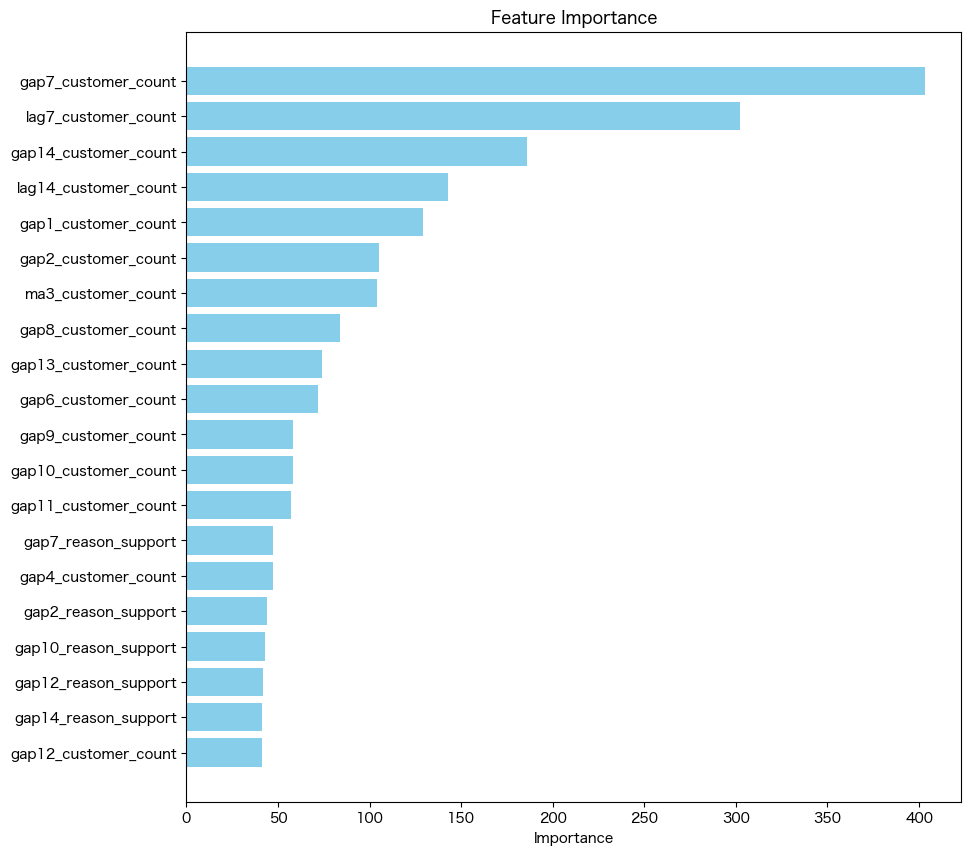

In [528]:
# 特徴量の重要度をプロット
importance_df = importance_df.sort_values(by='Importance', ascending=True)  # 重要度でソート
importance_df = importance_df.iloc[-20 :,:] # 最後の20個の特徴量を表示

plt.figure(figsize=(10, 10))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.show()  # プロットを表示